### analyze_all_simulation_PCAs



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
import matplotlib.colors as clr
from scipy.interpolate import interp1d
from matplotlib import cm
from matplotlib.lines import Line2D
import pickle
import sys
import os
file_path = 'C:/Users/dB/deBivort/projects/ALVariability/'
proj_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
sys.path.append(proj_dir)
from utils.plot_utils import set_font_sizes
from utils.data_utils import make_df_AL_activity_long, make_orn_upn_frs, make_glomerular_odor_responses
set_font_sizes()

In [2]:
project_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
df_neur_ids = pd.read_csv(os.path.join(project_dir, 'connectomics/hemibrain_v1_2/df_neur_ids.csv'), index_col=0)
al_block = pd.read_csv(os.path.join(project_dir, 'connectomics/hemibrain_v1_2/AL_block.csv'), index_col=0)
al_block.columns = al_block.columns.astype(np.int64)
al_block.index = al_block.index.astype(np.int64)
imput_table = pd.read_csv(os.path.join(project_dir, 'odor_imputation/df_odor_door_all_odors_imput_ALS.csv'), index_col=0)

In [3]:
#df_char_ids = d_sims[good_orn_set[0]]['df_char_ids']
#hemi_gloms = df_char_ids[df_char_ids['altype'] == 'ORN']['glom'].unique()
hemi_gloms = np.array(['DA1', 'VC5', 'VA1v', 'VA1d', 'VA2', 'VA6', 'DM1', 'DL3', 'DL1',
       'VL2a', 'VM4', 'VM5d', 'DM2', 'VL1', 'DM3', 'DM4', 'DM6', 'DL4',
       'VC3l', 'DC3', 'VM7d', 'V', 'VL2p', 'VM1', 'VC3m', 'DC1', 'DL5',
       'D', 'DP1m', 'VM5v', 'DA3', 'VC4', 'DA2', 'VA7m', 'VA3', 'DP1l',
       'DC4', 'VC2', 'VA4', 'DC2', 'VM7v', 'DM5', 'DL2v', 'VM3', 'VC1',
       'VA5', 'DL2d', 'VA7l', 'DA4l', 'DA4m', 'VM2'])

thermo_hygro_glomeruli = np.array(['VP1d', 'VP1l', 'VP1m', 'VP2', 'VP3', 'VP4', 'VP5'])

sim_odors = np.array(['3-octanol',
                        '1-hexanol',
                        'ethyl lactate',
                        #'citronella',
                        '2-heptanone',
                        '1-pentanol',
                        'ethanol',
                        'geranyl acetate',
                        'hexyl acetate',
                        '4-methylcyclohexanol',
                        'pentyl acetate',
                        '1-butanol'])

MAC_gloms = ['DC2', 'DL5', 'DM1', 'DM2', 'DM3']

## MAC PN calcium responses

In [4]:
# load MAC responses
df_MAC_PN_responses = pd.read_csv(os.path.join(project_dir, 'datasets/MAC/responsesNoResponseRemoved.csv'), header=None)
gNames = ['DC2', 'DL5', 'DM1', 'DM2', 'DM3']
oNames = np.array(['air', '3-octanol', '1-hexanol','ethyl lactate',
                      'citronella','2-heptanone','1-pentanol',
                        'ethanol','geranyl acetate','hexyl acetate',
                        '4-methylcyclohexanol', 'pentyl acetate', '1-butanol'])
df_MAC_PN_responses.columns = [f'fly{c}' for c in df_MAC_PN_responses.columns]

df_MAC_PN_responses['glom'] = np.repeat(gNames, 13)
df_MAC_PN_responses['odor'] = np.tile(oNames, 5)

df_MAC_PN_responses = df_MAC_PN_responses.set_index(['glom', 'odor'])

df_MAC_PN_responses

fly0      fly1      fly2      fly3      fly4  \
glom odor                                                                     
DC2  air                   0.260650  0.052726  0.129667  0.047172  0.215276   
     3-octanol             0.127699  1.019578  1.019578  1.019578  0.974672   
     1-hexanol             1.005398  0.517153  1.943049  1.991326  1.060851   
     ethyl lactate         0.210532 -0.147994  0.295596  0.634941  0.544314   
     citronella            0.448953  0.382975  0.353849  0.366421  0.664343   
...                             ...       ...       ...       ...       ...   
DM3  geranyl acetate       0.164666  0.164666  0.164666  0.164666  0.164666   
     hexyl acetate         1.466945  0.666556  1.421625  2.442097  1.239680   
     4-methylcyclohexanol  0.498458  0.421914  0.415465  0.102517  0.072890   
     pentyl acetate        1.254910  0.479678  1.796660  2.341711  0.857967   
     1-butanol             0.587231  0.223652  0.665239  0.606057  0.384341   

                               fly5      fly6      fly7      fly8      fly9  \
glom odor                                                                     
DC2  air                   0.012301  0.266031  0.061057  0.087956  0.067862   
     3-octanol             1.019578  1.019578  1.019578  1.019578  1.019578   
     1-hexanol             0.048440  0.836338  0.787543  1.292774  0.978063   
     ethyl lactate         0.182131  0.174571  0.137882  0.218298  0.686998   
     citronella            0.140258  0.766013  0.268388  1.098849  0.844658   
...                             ...       ...       ...       ...       ...   
DM3  geranyl acetate       0.164666  0.164666  0.164666  0.164666  0.164666   
     hexyl acetate         1.334081  1.260013  1.049306  0.741279  0.718613   
     4-methylcyclohexanol  0.041298  0.071671  0.120899  0.165812  0.206534   
     pentyl acetate        1.109033  1.877811  1.006252  1.320308  1.080152   
     1-butanol             0.284364  1.303859  0.329553  0.386100  0.316017   

                           ...    fly229    fly230    fly231    fly232  \
glom odor                  ...                                           
DC2  air                   ...  0.188817  0.142362  0.003441  0.299037   
     3-octanol             ...  1.055264  0.847613  1.198978  0.978518   
     1-hexanol             ...  0.590007  0.652000  0.608121  0.411354   
     ethyl lactate         ...  0.064622  0.176078 -0.038675  0.590331   
     citronella            ...  0.060916 -0.040474  0.010426  0.168153   
...                        ...       ...       ...       ...       ...   
DM3  geranyl acetate       ...  0.233381  0.011913  0.151933  0.057286   
     hexyl acetate         ...  1.264711  1.240096  1.032847  1.416774   
     4-methylcyclohexanol  ...  0.166566 -0.244783  0.040740  0.058347   
     pentyl acetate        ...  1.073642  1.239641  0.755259  1.277895   
     1-butanol             ...  0.147123  0.826189  0.243906  0.187632   

                             fly233    fly234    fly235    fly236    fly237  \
glom odor                                                                     
DC2  air                   0.045469  0.037195  0.195108  0.092381  0.327169   
     3-octanol             0.503789  0.281735  1.010737  1.120071  1.087135   
     1-hexanol             0.455094  0.403543  0.677922  1.034633  1.278839   
     ethyl lactate         0.090137  0.030822  0.039811  0.509755  0.264571   
     citronella            0.116490  0.143921  0.078182  0.293502  0.114835   
...                             ...       ...       ...       ...       ...   
DM3  geranyl acetate      -0.061350  0.159625  0.164666  0.069313  0.108532   
     hexyl acetate         0.791122  1.079797  1.238982  0.419732  1.338231   
     4-methylcyclohexanol  0.050679  0.299013  0.326855  0.162022  0.190526   
     pentyl acetate        0.622987  0.908621  1.247978  0.410913  1.338706   
     1-butanol             0.117899  0.325450  0.610231  0.12601

In [5]:
fly_responses_df_MAC = df_MAC_PN_responses.loc[(gNames, sim_odors), :]
fly_responses_MAC = fly_responses_df_MAC.T.values

pca_MAC = PCA()
pca_MAC.fit(fly_responses_MAC)

pca_scores_MAC = pca_MAC.transform(fly_responses_MAC)
pca_loadings_MAC = pca_MAC.components_.T

pca_var_explained_MAC = pca_MAC.explained_variance_ratio_

In [6]:
fly_responses_df_MAC.shape

(55, 239)

In [7]:
pca_loadings_df_MAC = pd.DataFrame(pca_loadings_MAC, 
                                   index=fly_responses_df_MAC.index, 
                                   columns=[f'PC{i+1} ({int(100*pca_var_explained_MAC[i])}%)' for i in range(pca_loadings_MAC.shape[1])])

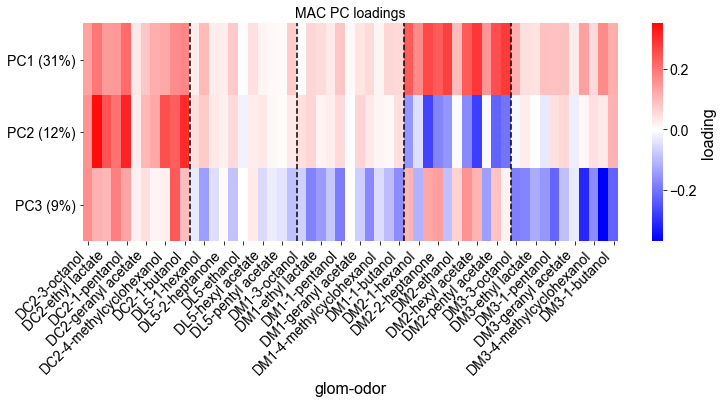

In [8]:
plt.figure(figsize=(12,4))
sns.heatmap(pca_loadings_df_MAC.iloc[:, :3].T, cmap='bwr', center=0, cbar_kws={'label': 'loading'})
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
for i in np.arange(11, 55, 11):
    plt.axvline(i, ls='--', c='k')
plt.title('MAC PC loadings')
plt.show()

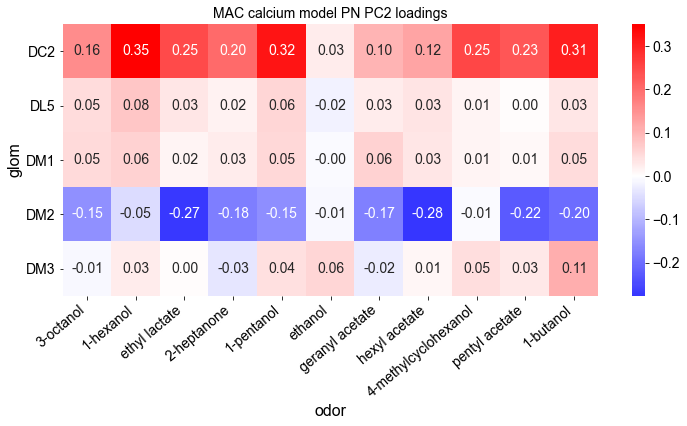

In [9]:
plt.figure(figsize=(12,5))
sns.heatmap(pd.DataFrame(pca_loadings_df_MAC.iloc[:, 1])
            .reset_index().pivot('glom', 'odor', 'PC2 (12%)')
            .loc[gNames, sim_odors],
            annot=True, fmt='.2f', center=0, cmap='bwr')
plt.yticks(rotation=0); plt.xticks(rotation=40, ha='right')
plt.title('MAC calcium model PN PC2 loadings')
plt.show()

### simulation PCAs

#### Figure 4g-k

In [10]:
d_pca_loadings_synapse = pickle.load(open('sim_PCA_loadings_synNoise.p', 'rb'))
d_pca_loadings_resampling_no_cone = pickle.load(open('sim_PCA_loadings_resampling_no_cone.p', 'rb'))
d_pca_loadings_resampling_with_cone = pickle.load(open('sim_PCA_loadings_resampling_with_cone.p', 'rb'))

d_pca_loadings = {**d_pca_loadings_synapse, **d_pca_loadings_resampling_no_cone}
d_pca_loadings = {**d_pca_loadings, **d_pca_loadings_resampling_with_cone}

In [12]:
d_pca_loadings['MAC'] = pca_loadings_df_MAC

In [13]:
keys_to_plot = ['MAC', 'No resampling (PN cone) (986)', '+ ORN (980)', '+ LN (946)', 'No synaptic noise (1020)']
tits = ['calcium', 'PN synapse density variation', 'ORN bootstrapping', 'LN bootstrapping', 'poisson timing variation', ]

In [14]:
sign_flips = [1, 1, 1, # calcium
              1, -1, -1, # PN synapse density
              -1, -1, -1,  # ORN bootstrapping
              -1, -1, -1,  # LN bootstrapping
              -1, -1, -1] # poisson timing 

In [15]:
cmap_rgbs = interp1d(np.array([0, 127, 128, 255]),
                np.array([[0, 1, 1], [0.9921, 1, 1], [1, 0.9921, 0.9921], [1, 0, 0]]),
                axis=0)(np.arange(256))
cmap = clr.LinearSegmentedColormap.from_list('red_to_cyan', cmap_rgbs)

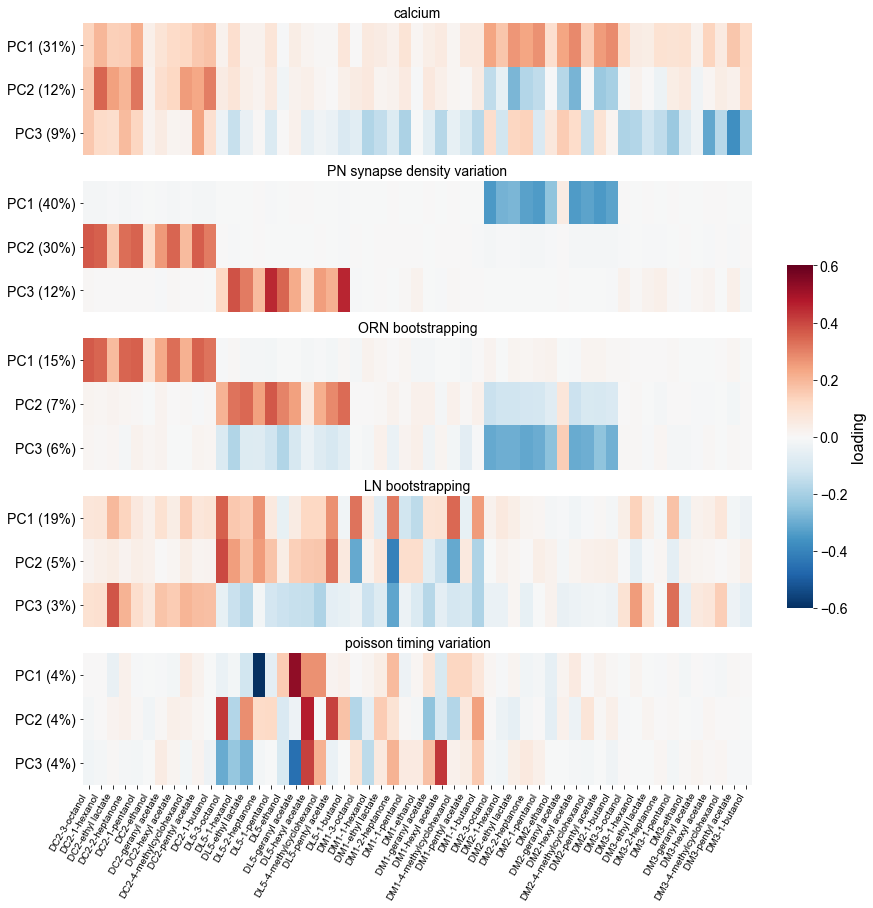

In [16]:
MASTER_PLOT_DIR = '../figures/main_text_figure/'
saveplot=False
nplots = len(keys_to_plot)
fig, axs = plt.subplots(nplots, 1, figsize=(12, 14))

b = 0.33
cbar_ax = fig.add_axes([.94, .3, .03, 1-2*b])

for i in range(nplots):
    ax_i = i
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
    pca_loadings_df = d_pca_loadings[cond_i]
       
    cur_df = pca_loadings_df.copy().iloc[:, :3].T
    for j in range(3):
        cur_df.iloc[j] *= sign_flips[3*i + j]    
    
    g = sns.heatmap(cur_df, 
                cmap='RdBu_r', center=0, cbar_kws={'label': 'loading'}, cbar_ax=cbar_ax,
                ax=axs[ax_i], vmin=-0.6, vmax=0.6,
                xticklabels=True, )
    #for i in np.arange(11, 55, 11):
    #    axs[ax_i].axvline(i, ls='--', c='k')
    axs[ax_i].set_title(f'{tit_i}')
    axs[ax_i].set_xlabel('')
    g.set_xticklabels(g.get_xticklabels(), rotation=60, ha='right', size=10)
    if ax_i < 4:
        axs[ax_i].set_xticks([])
        
    
plt.yticks(rotation=0)#; plt.xticks(rotation=45, ha='right')
if saveplot:
    plt.savefig(os.path.join(MASTER_PLOT_DIR, 'simulation_pca_loadings.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(MASTER_PLOT_DIR, 'simulation_pca_loadings.png'), bbox_inches='tight', dpi=200)
plt.show()

### all resampling experiment PCA results

#### Supplementary figure 16

In [17]:
sim_title_dic = {
    'No synaptic noise (1020)': 'poisson timing variation',
 'N(0, 20%) noise (983)': 'N(0, 20%) synapse noise',
 'N(0, 50%) noise (937)': 'N(0, 50%) synapse noise',
 'N(0, 100%) noise (993)': 'N(0, 100%) synapse noise',
 'No resampling (PN cone) (986)': 'no resampling, PN synapse density variation',
 '+ ORN (PN cone) (980)': '+ ORN resampling, PN synapse density variation',
 '+ LN (PN cone) (968)': '+ LN resampling, PN synapse density variation',
 '+ PN (PN cone) (941)': '+PN resampling, PN synapse density variation',
 '+ ORN + LN + PN (PN cone) (964)': '+ ORN + LN + PN resampling, PN synapse density variation',
    'No resampling (923)': 'no resampling',
 '+ ORN (980)': '+ ORN resampling',
 '+ LN (946)': '+ LN resampling',
 '+ PN (961)': '+ PN resampling',
 '+ ORN + LN + PN (952)': '+ ORN + LN + PN resampling',
 'MAC': 'calcium'
}

In [19]:
sign_flips = [# poisson + synapse noise
    -1, -1, -1, 
    1, -1, 1, 
    -1, -1, 1, 
     1, -1, 1,
    # resampling, no PN synapse density variation
    1, 1, 1,
    -1, -1, -1,
    -1, -1, -1,
    -1, -1, -1,
    1, -1, 1,
    # resampling, PN synapse density variation
    1, -1, -1,
    1, -1, -1,
    1, -1, -1,
    1, -1, 1,
    1, -1, 1,]

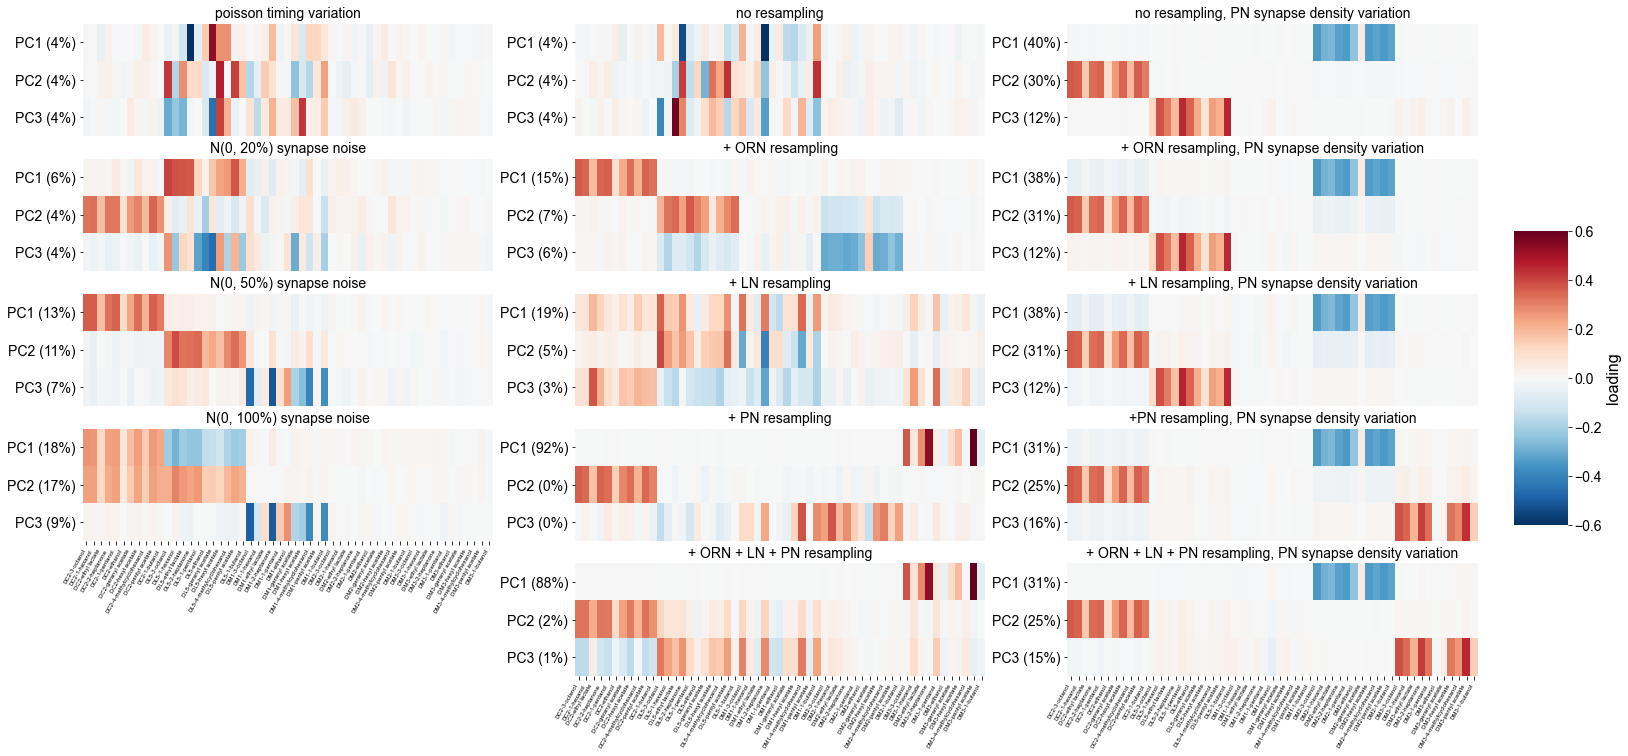

In [20]:
SUPFIG_DIR = '../figures/supfig16_all_pca_loadings/'

saveplot=False

all_keys = list(d_pca_loadings.keys())

keys_to_plot = all_keys[:-1] #['MAC', 'No resampling (PN cone) (986)', '+ ORN (980)', '+ LN (946)', 'No synaptic noise (1020)']
#keys_to_plot = keys_to_plot[:4] + keys_to_plot[-5:] + keys_to_plot[-10:-5]
tits = keys_to_plot #tits = ['calcium', 'glomerulus volume variation', 'ORN resampling', 'LN resampling', 'poisson timing variation', ]

plot_is = [0, 1, 2, 3] + list(np.arange(5, 15))

nplots = len(keys_to_plot)

fig, axs = plt.subplots(5, 3, figsize=(25, 12))

b = 0.33
cbar_ax = fig.add_axes([.92, .3, .03, 1-2*b])

for i in range(nplots):
    ax_i = plot_is[i]
    ax_row = ax_i % 5
    ax_col = ax_i // 5
    

    cond_i = keys_to_plot[i]
    tit_i = tits[i]
    
    pca_loadings_df = d_pca_loadings[cond_i]
       
    cur_df = pca_loadings_df.copy().iloc[:, :3].T
    for j in range(3):
        cur_df.iloc[j] *= sign_flips[3*i + j]    
    
    g = sns.heatmap(cur_df, 
                cmap='RdBu_r', center=0, cbar_kws={'label': 'loading'}, cbar_ax=cbar_ax,
                ax=axs[ax_row, ax_col], vmin=-0.6, vmax=0.6, xticklabels=True, )
    axs[ax_row, ax_col].set_title(f'{sim_title_dic[tit_i]}')
    axs[ax_row, ax_col].set_xlabel('')
    g.set_xticklabels(g.get_xticklabels(), rotation=60, ha='right', size=6)
    if (ax_row < 3) or ((ax_col > 0) and (ax_row < 4)):
        axs[ax_row, ax_col].set_xticks([])
        
axs[4, 0].axis('off')

plt.yticks(rotation=0)#; plt.xticks(rotation=45, ha='right')
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'all_simulation_pca_loadings.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'all_simulation_pca_loadings.png'), bbox_inches='tight', dpi=200)
plt.show()

### example firing rate vectors

#### Figure 4f

In [25]:
d_firing_rates_synapse = pickle.load(open('sim_firing_rates_synNoise.p', 'rb'))
d_firing_rates_resampling_no_cone = pickle.load(open('sim_firing_rates_resampling_no_cone.p', 'rb'))
d_firing_rates_resampling_with_cone = pickle.load(open('sim_firing_rates_resampling_with_cone.p', 'rb'))

d_firing_rates = {**d_firing_rates_synapse, **d_firing_rates_resampling_no_cone}
d_firing_rates = {**d_firing_rates, **d_firing_rates_resampling_with_cone}

d_firing_rates['MAC'] = fly_responses_df_MAC

In [26]:
keys_to_plot = ['No synaptic noise (1020)', 'No resampling (PN cone) (986)', '+ ORN (980)', '+ LN (946)']
tits = ['poisson timing variation', 'PN synapse density variation', 'ORN bootstrapping', 'LN bootstrapping', ]

In [27]:
n_flies = 50

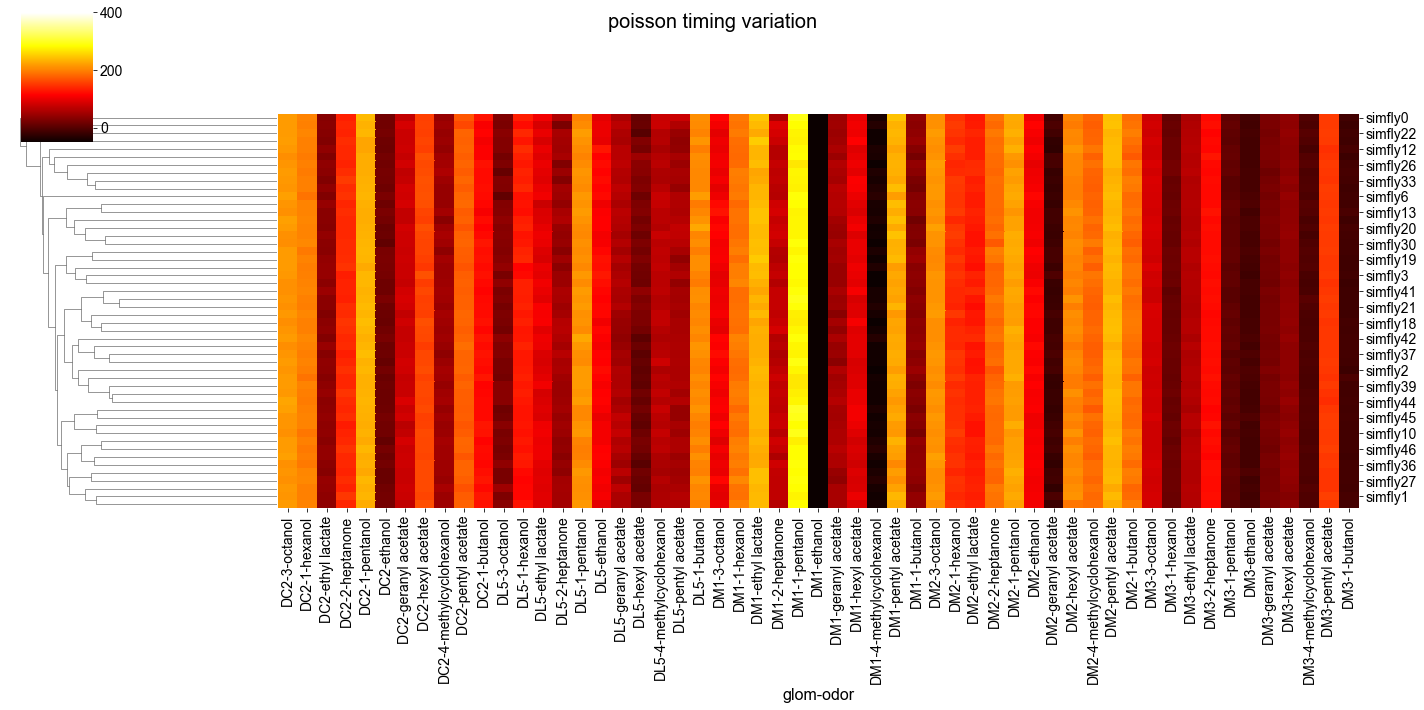

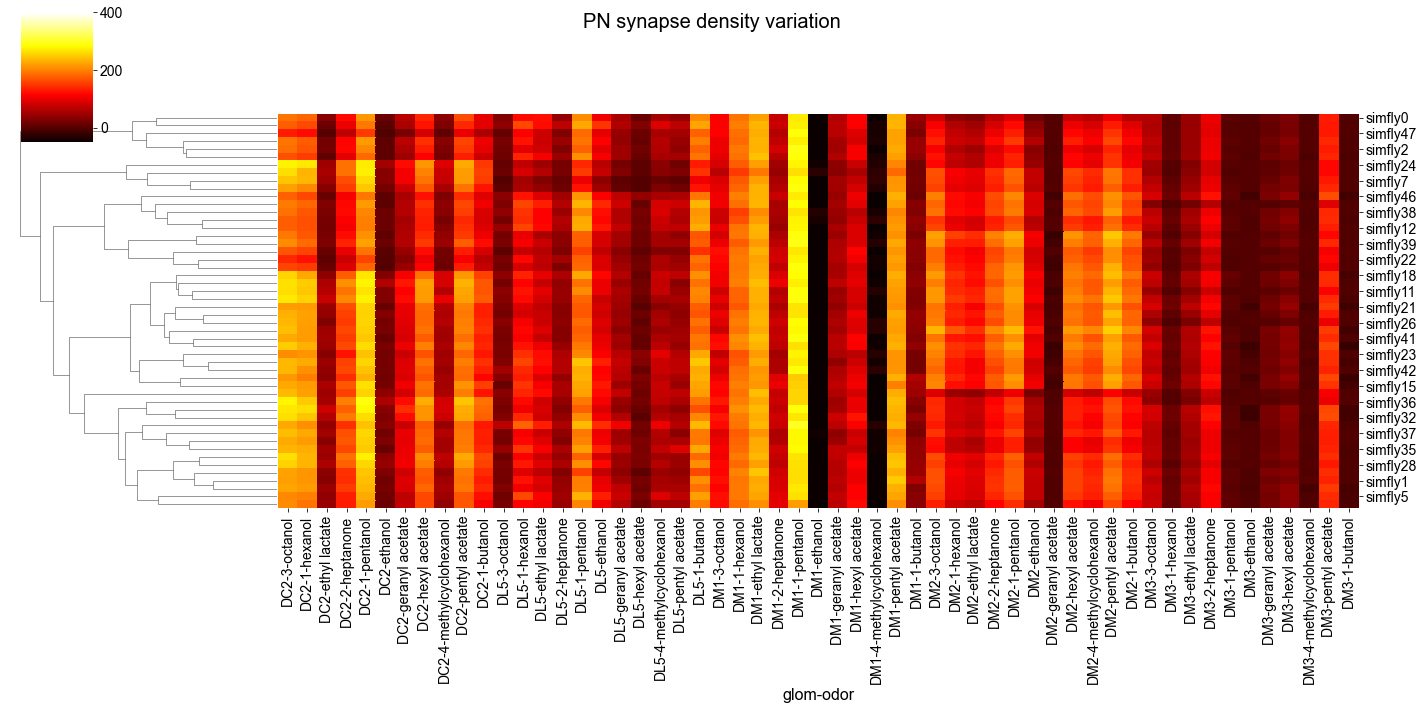

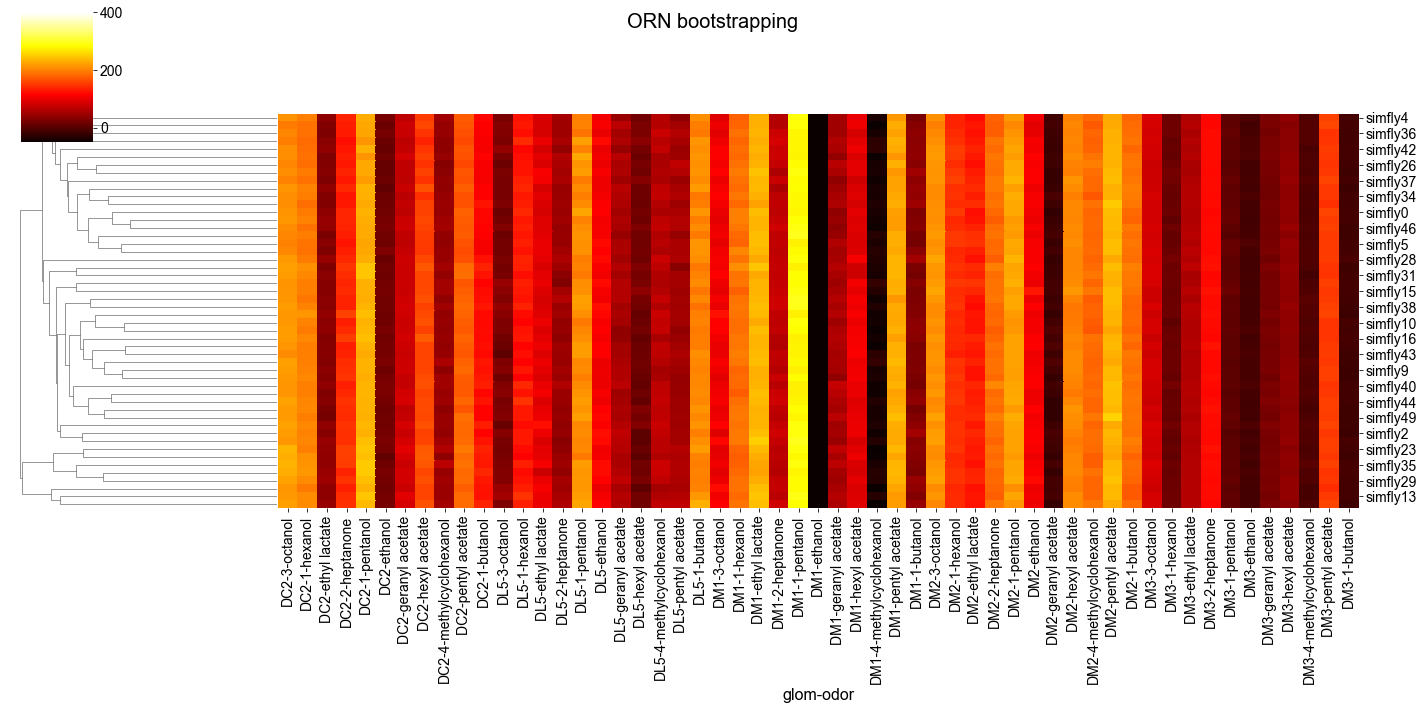

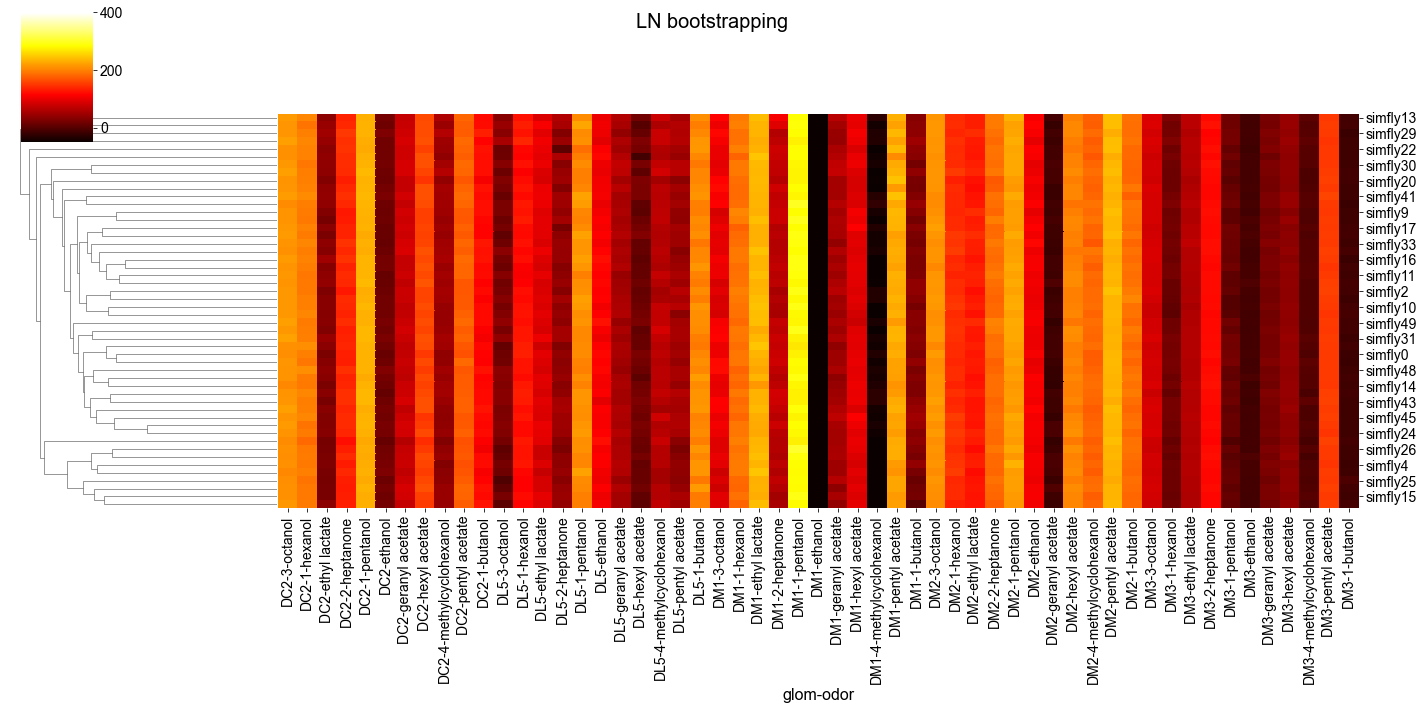

IndexError: list index out of range

In [28]:
d_cluster_orders = {}
for i in range(nplots):
    ax_i = i
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
    
    df = d_firing_rates[cond_i].T.iloc[:n_flies]
    
    #fig, ax = plt.subplots()
    #\plt.title(tit_i)
    g = sns.clustermap(df, figsize=(20, 10), 
                       col_cluster = False, cmap='hot', vmin=-50, vmax=400)
    g.fig.suptitle(tit_i)
    #g.ax_heatmap.set_xticklabels(g.get_xticklabels(), rotation=60, ha='right', size=10)
    plt.savefig(f'clustering_{tit_i}.png', dpi=400)
    
    fly_cluster_order = g.data2d.index.values
    d_cluster_orders[tit_i] = fly_cluster_order
    
    plt.show()

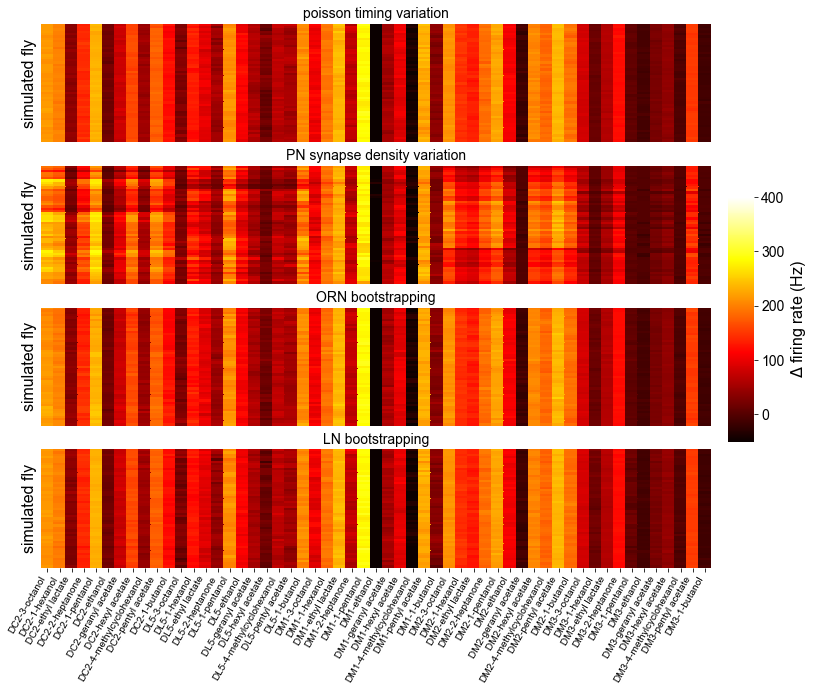

In [29]:
%matplotlib inline

MASTER_PLOT_DIR = '../figures/main_text_figure/'
saveplot=False
nplots = len(keys_to_plot)
fig, axs = plt.subplots(nplots, 1, figsize=(12, 10))

#fig2, axs2 = plt.subplots(nplots, 1, figsize=(12, 10), sharex=True)


b = 0.33
# [left, bottom, width, height]
cbar_ax = fig.add_axes([.92, .3, .03, 1-2*b])

for i in range(nplots):
    ax_i = i
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
       
    df = d_firing_rates[cond_i].T.iloc[:n_flies]   
    
    fly_order_clustermap = d_cluster_orders[tit_i]
    
    
    #axs2[ax_i].hist(df.values.flatten(), bins=30)
    #axs2[ax_i].set_title(tit_i)
    
    g = sns.heatmap(df.loc[fly_order_clustermap], 
                cmap='hot', cbar_kws={'label': r'$\Delta$ firing rate (Hz)'}, cbar_ax=cbar_ax,
                ax=axs[ax_i], vmin=-50, vmax=400, #center=100,
                xticklabels=True, )

    axs[ax_i].set_title(f'{tit_i}')
    axs[ax_i].set_xlabel('')
    g.set_xticklabels(g.get_xticklabels(), rotation=60, ha='right', size=10)
    
    axs[ax_i].set_yticks([])
    axs[ax_i].set_ylabel('simulated fly')
    if ax_i < 3:
        axs[ax_i].set_xticks([])

    
plt.yticks(rotation=0)#; plt.xticks(rotation=45, ha='right')
if saveplot:
    plt.savefig(os.path.join(MASTER_PLOT_DIR, f'simulation_example_firing_rates_{n_flies}.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(MASTER_PLOT_DIR, f'simulation_example_firing_rates_{n_flies}.png'), bbox_inches='tight', dpi=200)
plt.show()

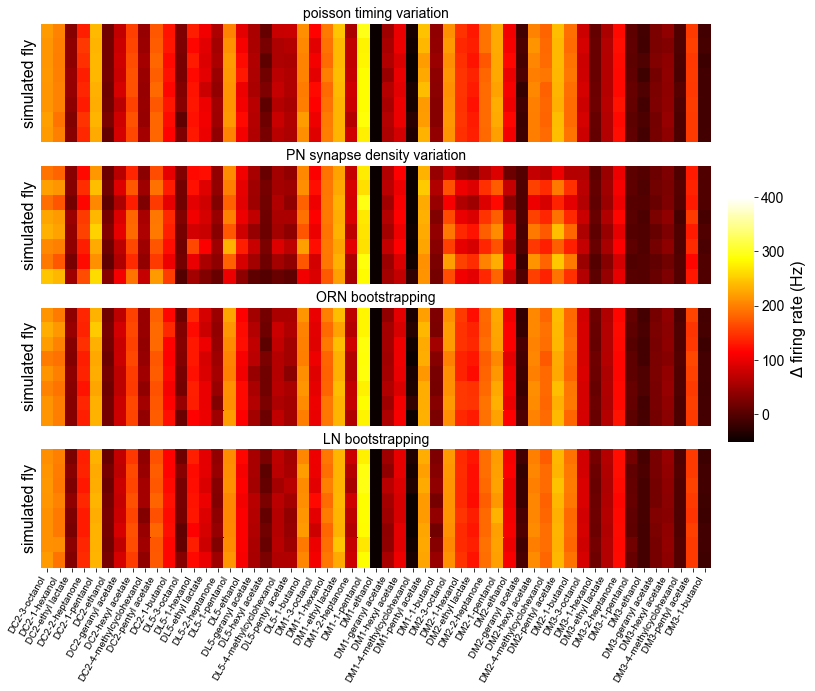

In [30]:
%matplotlib inline

MASTER_PLOT_DIR = '../figures/main_text_figure/'
saveplot=False
nplots = len(keys_to_plot)
fig, axs = plt.subplots(nplots, 1, figsize=(12, 10))

n_flies = 8

b = 0.33
# [left, bottom, width, height]
cbar_ax = fig.add_axes([.92, .3, .03, 1-2*b])

for i in range(nplots):
    ax_i = i
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
       
    df = d_firing_rates[cond_i].T.iloc[:n_flies]   
       
    g = sns.heatmap(df,
                cmap='hot', cbar_kws={'label': r'$\Delta$ firing rate (Hz)'}, cbar_ax=cbar_ax,
                ax=axs[ax_i], vmin=-50, vmax=400, #center=100,
                xticklabels=True, 
               )#linewidths=0.1, linecolor='k')

    axs[ax_i].set_title(f'{tit_i}')
    axs[ax_i].set_xlabel('')
    g.set_xticklabels(g.get_xticklabels(), rotation=60, ha='right', size=10)
    
    axs[ax_i].set_yticks([])
    axs[ax_i].set_ylabel('simulated fly')
    if ax_i < 3:
        axs[ax_i].set_xticks([])

    
plt.yticks(rotation=0)#; plt.xticks(rotation=45, ha='right')
if saveplot:
    plt.savefig(os.path.join(MASTER_PLOT_DIR, f'simulation_example_firing_rates_{n_flies}.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(MASTER_PLOT_DIR, f'simulation_example_firing_rates_{n_flies}.png'), bbox_inches='tight', dpi=200)
plt.show()

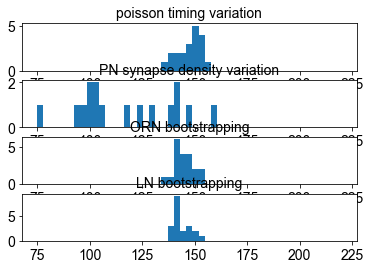

In [31]:
ix = 53

fig, axs = plt.subplots(4, 1)

for i in range(4):
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
    axs[i].set_title(tit_i)
    df = d_firing_rates[cond_i].T.iloc[:20] 
    axs[i].hist(df['DM2']['1-hexanol'],#df.iloc[:, ix],
             label=cond_i, bins=np.linspace(75,220, 50))
#plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.show()

In [33]:
gNames

['DC2', 'DL5', 'DM1', 'DM2', 'DM3']

In [34]:
cond_i

'+ LN (946)'

In [35]:
i = 3
cond_i = keys_to_plot[i]
df = d_firing_rates[cond_i].T#.iloc[:20]

pca = PCA()
pca.fit(df)
pca_scores = pca.transform(df)
pca_loadings = pca.components_.T
loadings_df = pd.DataFrame(pca_loadings,
                          index=df.columns, 
                          columns=[f'PC{i+1}' for i in range(pca_loadings.shape[1])])

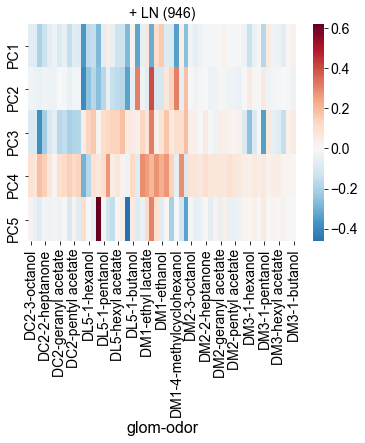

In [36]:
plt.figure()
plt.title(cond_i)
sns.heatmap(loadings_df.T.iloc[:5], cmap='RdBu_r', center=0)
plt.show()

In [39]:
keys_to_plot = ['MAC', 'No resampling (PN cone) (986)', '+ ORN (980)', '+ LN (946)', 'No synaptic noise (1020)']
tits = ['calcium', 'glomerulus volume variation', 'ORN resampling', 'LN resampling', 'poisson timing variation', ]

In [40]:
MAC_PC2 = pca_loadings_df_MAC.iloc[:, 1]

In [41]:
keys_to_plot

['MAC',
 'No resampling (PN cone) (986)',
 '+ ORN (980)',
 '+ LN (946)',
 'No synaptic noise (1020)']

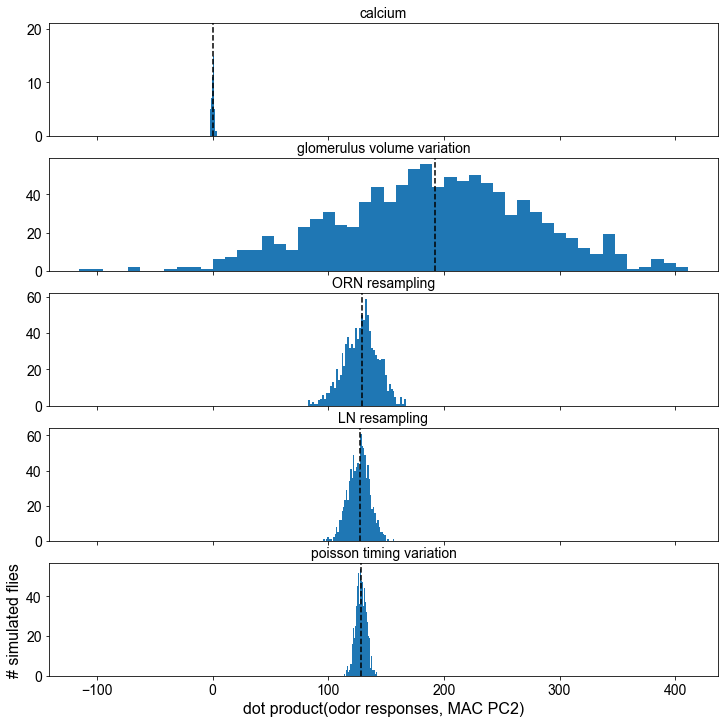

In [42]:
%matplotlib inline

saveplot=False
nplots = len(keys_to_plot)
fig, axs = plt.subplots(nplots, 1, figsize=(12, 12), sharex=True)

b = 0.33

for i in range(nplots):
    ax_i = i
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
    
    # get simulated fly firing rates
    fly_responses_df_sim_macgloms = d_firing_rates[cond_i]
    fly_responses_sim_macgloms = fly_responses_df_sim_macgloms.T.values
    
    # get PCA scores
    pca_sim_macgloms = PCA()
    pca_sim_macgloms.fit(fly_responses_sim_macgloms)
    pca_scores_sim_macgloms = pca_sim_macgloms.transform(fly_responses_sim_macgloms)
    
    # get behavioral score
    sim_behavior_scores = fly_responses_df_sim_macgloms.multiply(MAC_PC2, 0).sum(0)
    median_behavior_score = np.median(sim_behavior_scores)
    sim_bin_behavior_scores = (sim_behavior_scores > median_behavior_score).astype(int)
    
    axs[ax_i].hist(sim_behavior_scores, bins=50)
    axs[ax_i].axvline(median_behavior_score, c='k', ls='--')
    
    axs[ax_i].set_title(f'{tit_i}')
    axs[ax_i].set_xlabel('')
    
plt.ylabel('# simulated flies')
plt.xlabel('dot product(odor responses, MAC PC2)')    
if saveplot:
    plt.savefig(os.path.join(MASTER_PLOT_DIR, 'simulation_pca_loadings.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(MASTER_PLOT_DIR, 'simulation_pca_loadings.png'), bbox_inches='tight', dpi=200)
plt.show()

In [80]:
sim_behavior_scores

simfly0      116.341782
simfly1      122.184490
simfly2      122.814449
simfly3      139.965453
simfly4      110.753453
                ...    
simfly941    121.425043
simfly942    113.893170
simfly943    113.670341
simfly944    138.171019
simfly945    145.725941
Length: 946, dtype: float64

In [81]:
median_behavior_score

127.10118449633

In [43]:
from sklearn import svm

In [63]:
SUPFIG_DIR = '../figures/supfig17_classifiability/'

<IPython.core.display.Javascript object>


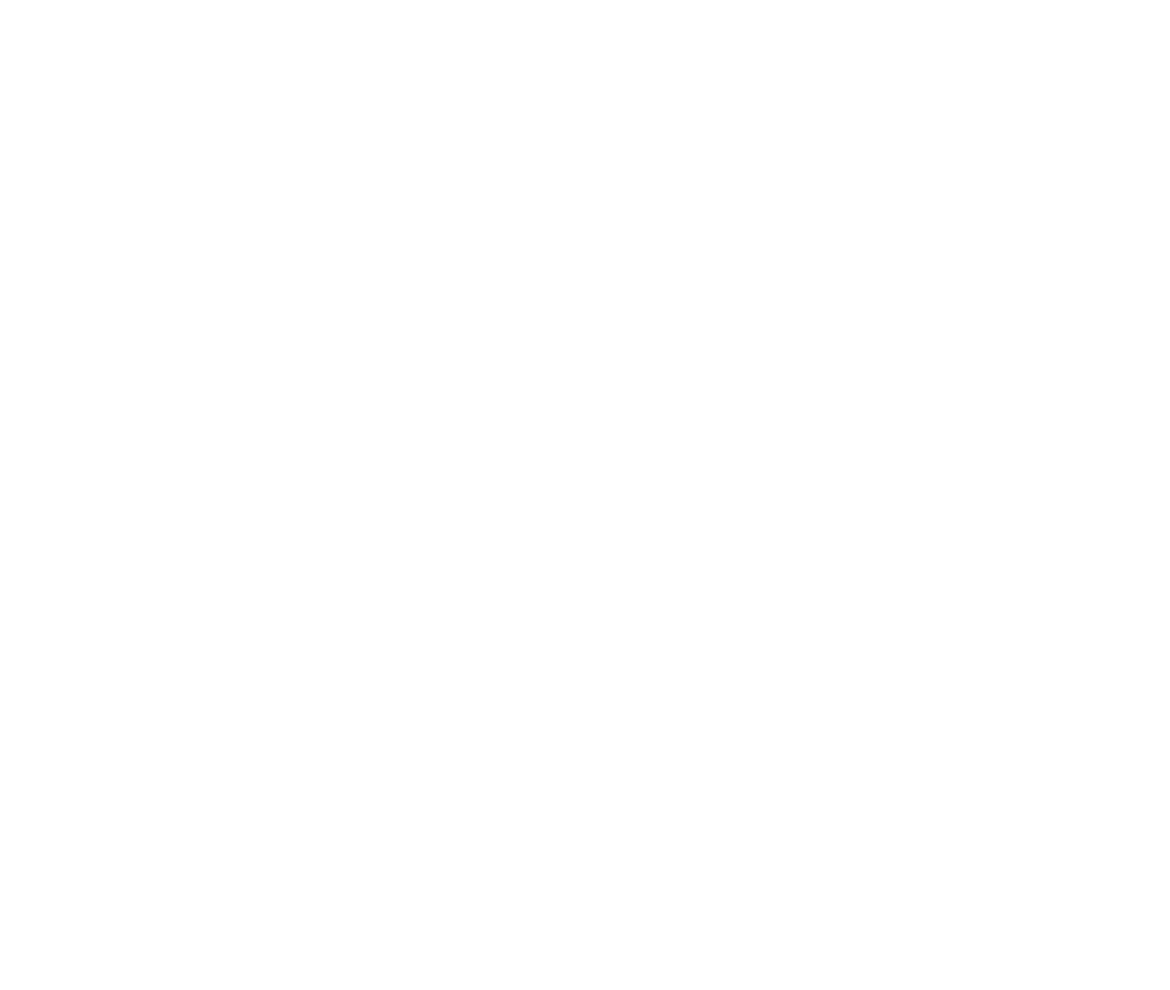

NameError: name 'd_firing_rates' is not defined

In [6]:
np.random.seed(1234)

%matplotlib notebook
%matplotlib notebook

keys_to_plot = ['No synaptic noise (1020)', 'No resampling (PN cone) (986)', '+ ORN (980)', '+ LN (946)']
tits = ['poisson timing variation', 'PN synapse density variation', 'ORN bootstrapping', 'LN bootstrapping', ]


saveplot=0
nplots = len(keys_to_plot)
fig = plt.figure(figsize=(13, 11))

b = 0.33

coefs = {}

plot_locs = [0, 1, 2, 3]#1, 2, 4, 5]
df_errors = []
for i in range(nplots):
    ax_i = i
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
    
    # get simulated fly firing rates
    fly_responses_df_sim_macgloms = d_firing_rates[cond_i]
    fly_responses_sim_macgloms = fly_responses_df_sim_macgloms.T.values
    
    # get PCA scores
    pca_sim_macgloms = PCA()
    pca_sim_macgloms.fit(fly_responses_sim_macgloms)
    pca_scores_sim_macgloms = pca_sim_macgloms.transform(fly_responses_sim_macgloms)
    
    # get behavioral score
    sim_behavior_scores = fly_responses_df_sim_macgloms.multiply(MAC_PC2, 0).sum(0)
    median_behavior_score = np.median(sim_behavior_scores)
    sim_bin_behavior_scores = (sim_behavior_scores > median_behavior_score).astype(int)
    
    # find hyperplane
    X = pca_scores_sim_macgloms[:, :3]
    Y = sim_bin_behavior_scores

    clf = svm.LinearSVC()
    clf.fit(X, Y)
    frac_error = np.sum(clf.predict(X) != Y) / len(Y)
    df_errors.append([tit_i, frac_error*100])
    coefs[tit_i] = clf.coef_[0]

    ax = fig.add_subplot(2, 2, plot_locs[i]+1, projection='3d')
    
    plot_arr = pca_scores_sim_macgloms[:, :3]

    ax.scatter(plot_arr[:, 0], plot_arr[:, 1], plot_arr[:, 2],
                c=sim_bin_behavior_scores)
    
    z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]
    
    maxcoord = np.max(np.max(np.abs(plot_arr)))
    tmp = np.linspace(-maxcoord*0.6,maxcoord*0.6,10)
    x,y = np.meshgrid(tmp,tmp)
    #ax.plot_surface(x, y, z(x,y))
    ax.set_xlabel('PC1', labelpad=12); ax.set_ylabel('PC2', labelpad=12); ax.set_zlabel('PC3', labelpad=12)
    ax.set_title(f'{tit_i}\n{int(round(frac_error*100, 0))}% misclassified')
    
    if i == 0: # calcium
        ax.view_init(azim=-3, elev=46)
    if i == 0: # poisson
        ax.view_init(azim=-109, elev=41)
    if i == 1: # PN synapse
        ax.view_init(azim=22, elev=33)
    if i == 2: # ORN bootstrapping
        ax.view_init(azim=-100, elev=37)
    if i == 3: # LN bootstrapping
        ax.view_init(azim=-105, elev=36)
    

plt.subplots_adjust(hspace=0.5, wspace=0.8)
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.05, right=0.75, hspace=0.18, wspace=0.2)
plt.savefig('foob.png', bbox_inches='tight')

if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'behavioral_classification_scatter.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'behavioral_classification_scatter.png'), bbox_inches='tight', dpi=200)
plt.show()

<IPython.core.display.Javascript object>


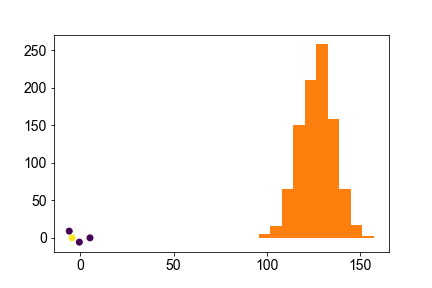

In [74]:
plt.figure()
plt.scatter(plot_arr[:4, 0], plot_arr[:4, 1], c=sim_bin_behavior_scores[:4])
plt.show()

In [75]:
sim_bin_behavior_scores[:4]

simfly0    0
simfly1    0
simfly2    0
simfly3    1
dtype: int32

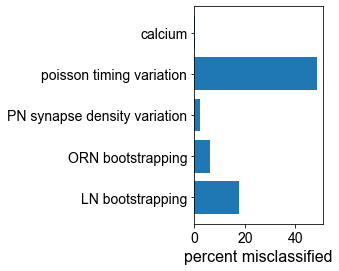

In [272]:
%matplotlib inline

saveplot = True
df_errors = pd.DataFrame(df_errors, columns=['condition', 'fraction misclassified'])
fig, ax = plt.subplots(figsize=(2.3,4))
ax.barh(df_errors['condition'], df_errors['fraction misclassified'])
plt.xlabel('percent misclassified')
ax.invert_yaxis()
if saveplot:
    plt.savefig(os.path.join(SUPFIG_DIR, 'behavioral_classification_scores.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(SUPFIG_DIR, 'behavioral_classification_scores.png'), bbox_inches='tight', dpi=200)
plt.show()

In [4]:
np.random.seed(1234)

%matplotlib notebook
%matplotlib notebook

saveplot=False
nplots = len(keys_to_plot)
fig = plt.figure(figsize=(6, 25))

b = 0.33

coefs = {}

plot_locs = [0, 1, 2, 3, 4]#, 5]
df_errors = []
for i in range(nplots):
    ax_i = i
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
    
    # get simulated fly firing rates
    fly_responses_df_sim_macgloms = d_firing_rates[cond_i]
    fly_responses_sim_macgloms = fly_responses_df_sim_macgloms.T.values
    
    # get PCA scores
    pca_sim_macgloms = PCA()
    pca_sim_macgloms.fit(fly_responses_sim_macgloms)
    pca_scores_sim_macgloms = pca_sim_macgloms.transform(fly_responses_sim_macgloms)
    
    # get behavioral score
    sim_behavior_scores = fly_responses_df_sim_macgloms.multiply(MAC_PC2, 0).sum(0)
    median_behavior_score = np.median(sim_behavior_scores)
    sim_bin_behavior_scores = (sim_behavior_scores > median_behavior_score).astype(int)
    
    # find hyperplane
    X = pca_scores_sim_macgloms[:, :3]
    Y = sim_bin_behavior_scores

    clf = svm.LinearSVC()
    clf.fit(X, Y)
    frac_error = np.sum(clf.predict(X) != Y) / len(Y)
    df_errors.append([tit_i, frac_error*100])
    coefs[tit_i] = clf.coef_[0]

    ax = fig.add_subplot(5, 1, plot_locs[i]+1, projection='3d')
    
    plot_arr = pca_scores_sim_macgloms[:, :3]

    ax.scatter(plot_arr[:, 0], plot_arr[:, 1], plot_arr[:, 2],
                c=sim_bin_behavior_scores)
    
    z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]
    
    maxcoord = np.max(np.max(np.abs(plot_arr)))
    tmp = np.linspace(-maxcoord*0.6,maxcoord*0.6,10)
    x,y = np.meshgrid(tmp,tmp)
    #ax.plot_surface(x, y, z(x,y))
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    ax.set_title(f'{tit_i}\n{round(frac_error*100, 2)}% misclassified')
    
    if i == 0:
        ax.view_init(azim=-3, elev=46)
    if i == 1:
        ax.view_init(azim=-11, elev=79)
    if i == 2:
        ax.view_init(azim=-100, elev=37)
    if i == 3:
        ax.view_init(azim=-105, elev=36)
    if i == 4:
        ax.view_init(azim=-109, elev=41)
    
        
plt.subplots_adjust(hspace=0.5, wspace=0.8)
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2, right=0.75)
#plt.savefig('foob.png')
#plt.savefig('foob3.pdf')
plt.show()

NameError: name 'keys_to_plot' is not defined

In [ ]:
def U(a):
    b = 10 - a
    return 2*b + a**2

In [ ]:
a_s = np.arange(0, 10)
b_s = 10 - a_s

In [ ]:
plt.figure()
plt.plot(a_s, U(a_s), 'o-')
plt.show()

In [ ]:
U(2)

In [ ]:
for i in [0, 1]:
    1
else:
    5

In [ ]:
%matplotlib inline

df_coefs = pd.DataFrame(coefs).T
df_coefs.columns = [f'PC{i+1}' for i in range(df_coefs.shape[1])]
plt.figure()
sns.heatmap(df_coefs, cmap='bwr', center=0, annot=True, fmt='.2f')
plt.xlabel('coefficient in hyperplane')
plt.show()

In [ ]:
df_errors

In [ ]:
%matplotlib inline

df_coefs_normed = (df_coefs.T**2 / (df_coefs**2).sum(1)).T
#df_coefs_normed = (np.abs(df_coefs).T / np.abs(df_coefs).sum(1)).T

df_coefs_normed = (df_coefs.T / np.sum(df_coefs**2, 1) ** 0.5).T

plt.figure(figsize=(6, 10))
plt.subplot(211)
sns.heatmap(df_coefs_normed, cmap='bwr', center=0, annot=True, fmt='.2f')
plt.xlabel('coefficient in plane normal')

plt.subplot(212)
sns.heatmap(np.abs(df_coefs_normed), cmap='Reds', vmin=0, vmax=1, annot=True, fmt='.2f')
plt.xlabel('abs(coefficient in plane normal)')
plt.show()

In [ ]:
df_coefs_normed.iloc[3]**2

In [ ]:
%matplotlib notebook

saveplot=False
nplots = len(keys_to_plot)
fig = plt.figure(figsize=(14, 14))

b = 0.33

for i in range(3):
    ax_i = i
    cond_i = keys_to_plot[i]
    tit_i = tits[i]
    
    # get simulated fly firing rates
    fly_responses_df_sim_macgloms = d_firing_rates[cond_i]
    fly_responses_sim_macgloms = fly_responses_df_sim_macgloms.T.values
    
    # get PCA scores
    pca_sim_macgloms = PCA()
    pca_sim_macgloms.fit(fly_responses_sim_macgloms)
    pca_scores_sim_macgloms = pca_sim_macgloms.transform(fly_responses_sim_macgloms)
    
    # get behavioral score
    sim_behavior_scores = fly_responses_df_sim_macgloms.multiply(MAC_PC2, 0).sum(0)
    median_behavior_score = np.median(sim_behavior_scores)
    sim_bin_behavior_scores = (sim_behavior_scores > median_behavior_score).astype(int)
    
    # find hyperplane
    X = pca_scores_sim_macgloms[:, :3]
    Y = sim_bin_behavior_scores

    clf = svm.LinearSVC()
    clf.fit(X, Y)
    frac_error = np.sum(clf.predict(X) != Y) / len(Y)


    ax = fig.add_subplot(2, 2, ax_i+1, projection='3d')
    
    plot_arr = pca_scores_sim_macgloms[:, :3]
    
    z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]
    
    maxcoord = np.max(np.max(np.abs(plot_arr)))
    tmp = np.linspace(-maxcoord*0.6,maxcoord*0.6,10)
    x,y = np.meshgrid(tmp,tmp)
    ax.plot_surface(x, y, z(x,y))
    
    t_arr = np.vstack((np.zeros(3), 
                       100*clf.coef_[0]))
    ax.plot(t_arr[:, 0], t_arr[:, 1], t_arr[:, 2])
    
    
    
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    ax.set_title(f'{tit_i}\n{round(frac_error*100, 2)}% misclassified')
    ax.set_xlim(-400, 400); ax.set_ylim(-400, 400); ax.set_zlim(-400, 400)    
    
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2, right=0.75)
plt.show()